In [12]:
# -*- coding: utf-8 -*-
"""
Created on Wed May 1, 11:30:25 2020

@author: Sourabh Tirodkar
USC ID- 3589406164
EE559- Mathematical Pattern Recognition
Final Project
"""

import sklearn
import numpy as np
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import time
from sklearn.decomposition import PCA
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn import linear_model
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt



starttime=time.time()   

#reading csv files
#train data    
training_set=np.genfromtxt('/content/drive/My Drive/EE559- Mathematical Pattern Recognition/D_train.csv',dtype = float, delimiter= ',')
#train label
testing_set=np.genfromtxt('/content/drive/My Drive/EE559- Mathematical Pattern Recognition/D_test.csv',dtype = float, delimiter= ',')

#Extracting Labels
train_label=training_set[1:,1]
test_label=testing_set[1:,1]

#Accessing data
ip_data=training_set[1:,3:]
op_data=testing_set[1:,3:]

# Combining X,Y,Z coord of all 12 markers
#Train    
X_combined=ip_data[:,0:35:3]
Y_combined=ip_data[:,1:35:3]
Z_combined=ip_data[:,2:35:3]
#Test
X_combined_test=op_data[:,0:35:3]
Y_combined_test=op_data[:,1:35:3]
Z_combined_test=op_data[:,2:35:3]


# Extracting features
# Train
#Recorded pts of train
recorded_pt = (np.count_nonzero(~np.isnan(X_combined),axis=1))*3
# mean,std,min, max
f1=np.nanmean(X_combined,axis=1)
f2=np.nanmean(Y_combined,axis=1)
f3=np.nanmean(Z_combined,axis=1)
f4=np.nanstd(X_combined,axis=1)
f5=np.nanstd(Y_combined,axis=1)
f6=np.nanstd(Z_combined,axis=1)
f7=np.nanmin(X_combined,axis=1)
f8=np.nanmin(Y_combined,axis=1)
f9=np.nanmin(Z_combined,axis=1)
f10=np.nanmax(X_combined,axis=1)
f11=np.nanmax(Y_combined,axis=1)
f12=np.nanmax(Z_combined,axis=1)

#test
#Recorded pts of test
recorded_pt_test = (np.count_nonzero(~np.isnan(X_combined_test),axis=1))*3
# mean,std,min, max
f1_test=np.nanmean(X_combined_test,axis=1)
f2_test=np.nanmean(Y_combined_test,axis=1)
f3_test=np.nanmean(Z_combined_test,axis=1)
f4_test=np.nanstd(X_combined_test,axis=1)
f5_test=np.nanstd(Y_combined_test,axis=1)
f6_test=np.nanstd(Z_combined_test,axis=1)
f7_test=np.nanmin(X_combined_test,axis=1)
f8_test=np.nanmin(Y_combined_test,axis=1)
f9_test=np.nanmin(Z_combined_test,axis=1)
f10_test=np.nanmax(X_combined_test,axis=1)
f11_test=np.nanmax(Y_combined_test,axis=1)
f12_test=np.nanmax(Z_combined_test,axis=1)


#Making final matrix of features
final_matrix=np.zeros([13500,13])
final_matrix_test=np.zeros([21100,13])

final_matrix=np.column_stack((recorded_pt,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12))
final_matrix_test=np.column_stack((recorded_pt_test,f1_test,f2_test,f3_test,f4_test,f5_test,f6_test,f7_test,f8_test,f9_test,f10_test,f11_test,f12_test))

#PCA
'''Used for comparison purposes'''
#pca = PCA(n_components=4, svd_solver='full')
#pca.fit(final_matrix)
#final_matrix_pca = pca.transform(final_matrix)
#final_matrix_test_pca = pca.transform(final_matrix_test)

#LDA
lda = LinearDiscriminantAnalysis(solver='svd',n_components=4)
lda.fit(final_matrix,train_label)
final_matrix_lda = lda.transform(final_matrix)
final_matrix_test_lda = lda.transform(final_matrix_test)

train_data=final_matrix_lda
test_data=final_matrix_test_lda

#Pre-Processing
scaler = preprocessing.StandardScaler().fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

# Group for Split
groups = training_set[1:,2]

def classifier(train_data, train_label,clf):
    accuracy_store=[]
    
    logo = LeaveOneGroupOut()
    logo.get_n_splits(train_data, train_label, groups)

    logo.get_n_splits(groups=groups)  # 'groups' is always required
    for train_index, test_index in logo.split(train_data, train_label, groups):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = train_data[train_index], train_data[test_index]
        Y_train, Y_test = train_label[train_index], train_label[test_index]
        #print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

        clf.fit(X_train, Y_train)
        predicted_label_valid=clf.predict(X_test)
    
        #Accuracy 
        accuracy_valid=sklearn.metrics.accuracy_score(Y_test,predicted_label_valid)
        accuracy_store.append(accuracy_valid)


    Average_crossvalidation_accuracy=np.mean(accuracy_store)
    #print('Average_crossvalidation_accuracy:', Average_crossvalidation_accuracy)
    
    return Average_crossvalidation_accuracy
    

#SVM
print('1. SVM Classifier')
range_C= np.logspace(-2, 2, 10)
ACC=np.zeros([len(range_C),1])
for i in range(len(range_C)): #C value
  clf=SVC(C=range_C[i],kernel='rbf', gamma='auto')
  a=classifier(train_data,train_label,clf)
  ACC[i]= a
  ACC_matrix_svm=ACC

max_accuracy=np.amax(ACC_matrix_svm)
print("Max Cross Validation Accuracy:", max_accuracy)
max_index=np.where(ACC_matrix_svm==np.max(ACC_matrix_svm))
print("C value",range_C[max_index[0][0]])
best_C= range_C[max_index[0][0]]

clf_final = SVC(best_C, kernel='rbf',gamma='scale')
clf_final.fit(train_data, train_label)
predicted_label_valid=clf.predict(train_data)
accuracy_train_svm=sklearn.metrics.accuracy_score(train_label,predicted_label_valid)
print("Accuracy train SVM:",accuracy_train_svm)
predicted_label_test_svm=clf_final.predict(test_data)
accuracy_test_svm=sklearn.metrics.accuracy_score(test_label,predicted_label_test_svm)
print("Accuracy test SVM:",accuracy_test_svm)
print('.........')


# Naive Bayes
print('2. Naive Bayes Classifier')
range_var= np.logspace(-4, -2, 20)
ACC=np.zeros([len(range_var),1])
for j in range(len(range_var)):
    clf_bayes= GaussianNB(var_smoothing=range_var[j])
    b= classifier(train_data,train_label,clf_bayes)
    ACC[j]=b
    ACC_matrix_nb= ACC
    
max_accuracy=np.amax(ACC_matrix_nb)
print("Max Cross Validation Accuracy:", max_accuracy)
max_index=np.where(ACC_matrix_nb==np.max(ACC_matrix_nb))
print("Best Variance value",range_var[max_index[0][0]])
best_var= range_var[max_index[0][0]]

clf_bayes_final= GaussianNB(var_smoothing=best_var)
clf_bayes_final.fit(train_data, train_label)
predicted_label_bayes=clf_bayes.predict(train_data)
predicted_label_test_bayes=clf_bayes.predict(test_data)
#Accuracy 
accuracy_train_bayes=sklearn.metrics.accuracy_score(train_label,predicted_label_bayes)
print("Accuracy train Bayes:",accuracy_train_bayes)
accuracy_test_bayes=sklearn.metrics.accuracy_score(test_label,predicted_label_test_bayes)
print("Accuracy test Bayes:",accuracy_test_bayes)
print('.........')


# Random Forest
print('3. Random Forest Classifier')
range_estimators= np.linspace(1, 100, 20, dtype=int)
ACC=np.zeros([len(range_estimators),1])
for k in range(len(range_estimators)):
    clf_rf= RandomForestClassifier(n_estimators=range_estimators[k])
    c= classifier(train_data,train_label,clf_rf)
    ACC[k]=c
    ACC_matrix_rf= ACC
    
max_accuracy=np.amax(ACC_matrix_rf)
print("Max Cross Validation Accuracy:", max_accuracy)
max_index=np.where(ACC_matrix_rf==np.max(ACC_matrix_rf))
print("Best estimator value",range_estimators[max_index[0][0]])
best_estimator= range_estimators[max_index[0][0]]
best_estimator=best_estimator.astype(np.int64)

clf_rf_final = RandomForestClassifier(n_estimators=best_estimator)
clf_rf_final.fit(train_data, train_label)
predicted_label_rf=clf_rf_final.predict(train_data)
predicted_label_test_rf=clf_rf_final.predict(test_data)
#Accuracy 
accuracy_train_rf=sklearn.metrics.accuracy_score(train_label,predicted_label_rf)
print("Accuracy train RF:",accuracy_train_rf)
accuracy_test_rf=sklearn.metrics.accuracy_score(test_label,predicted_label_test_rf)
print("Accuracy test RF:",accuracy_test_rf)
print('.........')


# KNN Classifier
print('4. KNN Classifier')
range_neighbour= np.linspace(1, 100, 20, dtype=int)
ACC=np.zeros([len(range_neighbour),1])
for k in range(len(range_neighbour)):
    clf_knn= KNeighborsClassifier(n_neighbors=range_neighbour[k])
    d= classifier(train_data,train_label,clf_knn)
    ACC[k]=d
    ACC_matrix_knn= ACC
    
max_accuracy=np.amax(ACC_matrix_knn)
print("Max Cross Validation Accuracy:", max_accuracy)
max_index=np.where(ACC_matrix_knn==np.max(ACC_matrix_knn))
print("Best estimator value",range_neighbour[max_index[0][0]])
best_neighbour= range_neighbour[max_index[0][0]]
best_neighbour=best_neighbour.astype(np.int64)

clf_knn_final = KNeighborsClassifier(n_neighbors=best_neighbour)
clf_knn_final.fit(train_data, train_label)
predicted_label_knn=clf_knn_final.predict(train_data)
predicted_label_test_knn=clf_knn_final.predict(test_data)
#Accuracy 
accuracy_train_knn=sklearn.metrics.accuracy_score(train_label,predicted_label_knn)
print("Accuracy train KNN:",accuracy_train_knn)
accuracy_test_knn=sklearn.metrics.accuracy_score(test_label,predicted_label_test_knn)
print("Accuracy test KNN:",accuracy_test_knn)
print('.........')



#SGD
print('5. SGD')
range_tol= np.logspace(-4, -2, 20)
ACC=np.zeros([len(range_tol),1])
for j in range(len(range_tol)):
    clf_sgd= linear_model.SGDClassifier(max_iter=1000, tol=range_tol[j])
    b= classifier(train_data,train_label,clf_sgd)
    ACC[j]=b
    ACC_matrix_sgd= ACC
    
max_accuracy=np.amax(ACC_matrix_sgd)
print("Max Cross Validation Accuracy:", max_accuracy)
max_index=np.where(ACC_matrix_sgd==np.max(ACC_matrix_sgd))
print("Best Tol value",range_tol[max_index[0][0]])
best_tol= range_tol[max_index[0][0]]

clf_sgd_final = linear_model.SGDClassifier(max_iter=1000, tol=best_tol)
clf_sgd_final.fit(train_data, train_label)
predicted_label_sgd=clf_sgd_final.predict(train_data)
predicted_label_test_sgd=clf_sgd_final.predict(test_data)
#Accuracy 
accuracy_train_sgd=sklearn.metrics.accuracy_score(train_label,predicted_label_sgd)
print("Accuracy train SGD:",accuracy_train_sgd)
accuracy_test_sgd=sklearn.metrics.accuracy_score(test_label,predicted_label_test_sgd)
print("Accuracy test SGD:",accuracy_test_sgd)
print('.........')


#MLP
print('6. MLP')
range_hidden= np.linspace(50, 150, 10,dtype=int)
ACC=np.zeros([len(range_hidden),1])
for j in range(len(range_hidden)):
    clf_mlp= MLPClassifier(max_iter=1000, tol=range_hidden[j])
    b= classifier(train_data,train_label,clf_mlp)
    ACC[j]=b
    ACC_matrix_mlp= ACC
    
max_accuracy=np.amax(ACC_matrix_mlp)
print("Max Cross Validation Accuracy:", max_accuracy)
max_index=np.where(ACC_matrix_mlp==np.max(ACC_matrix_mlp))
print("Best Hidden layer value",range_hidden[max_index[0][0]])
best_hidden= range_hidden[max_index[0][0]]

clf_ppp = MLPClassifier(hidden_layer_sizes=best_hidden)
clf_ppp.fit(train_data, train_label)
predicted_label_pp=clf_ppp.predict(train_data)
predicted_label_test_pp=clf_ppp.predict(test_data)
#Accuracy 
accuracy_train_pp=sklearn.metrics.accuracy_score(train_label,predicted_label_pp)
print("Accuracy train MLP:",accuracy_train_pp)
accuracy_test_pp=sklearn.metrics.accuracy_score(test_label,predicted_label_test_pp)
print("Accuracy test MLP:",accuracy_test_pp)
print('.........')

#Dummy Classifier
print('7. Dummy Classifier')
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(train_data, train_label)
predicted_label_dummy=dummy_clf.predict(train_data)
predicted_label_test_dummy=dummy_clf.predict(test_data)
#Accuracy 
accuracy_train_dummy=sklearn.metrics.accuracy_score(train_label,predicted_label_dummy)
print("Accuracy train RANDOM:",accuracy_train_dummy)
accuracy_test_dummy=sklearn.metrics.accuracy_score(test_label,predicted_label_test_dummy)
print("Accuracy test RANDOM:",accuracy_test_dummy)
print('.........')

endtime=time.time()   
print('Time elapsed',endtime-starttime)



1. SVM Classifier
Max Cross Validation Accuracy: 0.9667407407407408
C value 0.21544346900318834
Accuracy train SVM: 0.9982222222222222
Accuracy test SVM: 0.9500450258306081
.........
2. Naive Bayes Classifier
Max Cross Validation Accuracy: 0.9222962962962963
Best Variance value 0.01
Accuracy train Bayes: 0.9558518518518518
Accuracy test Bayes: 0.8695198824588843
.........
3. Random Forest Classifier
Max Cross Validation Accuracy: 0.9373333333333334
Best estimator value 63
Accuracy train RF: 1.0
Accuracy test RF: 0.8250154035736291
.........
4. KNN Classifier
Max Cross Validation Accuracy: 0.9182222222222222
Best estimator value 6
Accuracy train KNN: 0.9971111111111111
Accuracy test KNN: 0.8489027916014977
.........
5. SGD
Max Cross Validation Accuracy: 0.9222222222222223
Best Tol value 0.004832930238571752
Accuracy train SGD: 0.943037037037037
Accuracy test SGD: 0.9167259111806246
.........
6. MLP
Max Cross Validation Accuracy: 0.9421481481481481
Best Hidden layer value 127
Accuracy tr

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[[4203   48  145   68    2]
 [  26 4253   50   40   33]
 [ 123    0 4513  143    0]
 [   0    0  118 3758   38]
 [   0   72   56   92 3318]]


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Text(42.0, 0.5, 'True Labels')

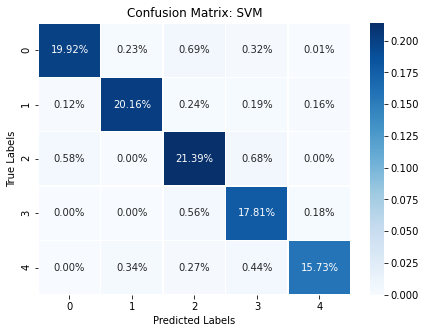

In [2]:
#Confusion Matrix
'''Changed variable and gave confusion matrix'''
import seaborn as sns
cf_matrix= confusion_matrix(test_label,predicted_label_test_svm)
print(cf_matrix)

fig,ax= plt.subplots(figsize=(7,5))
sns.heatmap((cf_matrix/np.sum(cf_matrix)), annot= True, linewidths=.5, ax=ax, fmt='.2%', cmap='Blues')
plt.title('Confusion Matrix: SVM')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

In [3]:
#Precision, Recall and F score
'''done for all the classifiers'''
from sklearn import metrics
print ('Random Forest')
print(metrics.classification_report(test_label, predicted_label_test_rf, digits=5))


Random Forest
              precision    recall  f1-score   support

         1.0    0.99361   0.97559   0.98452      4466
         2.0    0.68774   0.76352   0.72365      4402
         3.0    0.66532   0.86399   0.75175      4779
         4.0    0.56235   0.17629   0.26843      3914
         5.0    0.76422   0.94912   0.84670      3538

    accuracy                        0.75335     21099
   macro avg    0.73465   0.74570   0.71501     21099
weighted avg    0.73697   0.75335   0.72142     21099



Text(0.5, 1.0, 'Comparsion of different classifiers')

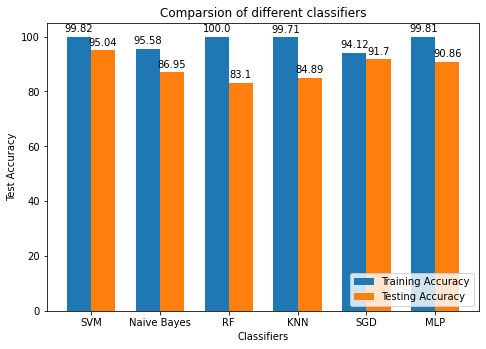

In [4]:
#Plot of comparing different classifiers
import numpy as np
import matplotlib.pyplot as plt
data = [[99.82, 95.58, 100, 99.71, 94.12, 99.81],
[95.04, 86.95, 83.10, 84.89, 91.70,90.86]]
width = 0.35  # the width of the bars
langs = ['SVM', 'Naive Bayes', 'RF', 'KNN', 'SGD','MLP']
x = np.arange(len(langs))
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
rects1 = ax.bar(x - width/2, data[0], width, label='Training Accuracy')
rects2 = ax.bar(x + width/2, data[1], width, label='Testing Accuracy')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

ax.set_xticks(x)
ax.set_xticklabels(langs)
ax.legend(loc='lower right')
ax.set_ylabel('Test Accuracy')
ax.set_xlabel('Classifiers')

ax.set_title('Comparsion of different classifiers')


Text(0.5, 1.0, 'Comparsion of different classifiers on standarization and non standarization')

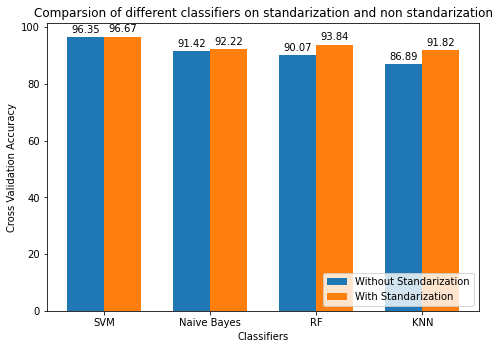

In [5]:
#Plot of comparing standariziation and non standarization on classifiers

import matplotlib.pyplot as plt
data = [[96.35, 91.42, 90.07, 86.89],[96.67, 92.22, 93.84, 91.82]]
width = 0.35  # the width of the bars
langs = ['SVM', 'Naive Bayes', 'RF', 'KNN']
x = np.arange(len(langs))
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
rects1 = ax.bar(x - width/2, data[0], width, label='Without Standarization')
rects2 = ax.bar(x + width/2, data[1], width, label='With Standarization')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

ax.set_xticks(x)
ax.set_xticklabels(langs)
ax.legend(loc='lower right')
ax.set_ylabel('Cross Validation Accuracy')
ax.set_xlabel('Classifiers')

ax.set_title('Comparsion of different classifiers on standarization and non standarization')
